# Process Monthly Safegraph Data
[Safegraph Data Schema](https://docs.safegraph.com/docs/monthly-patterns)

After downloading the raw zip files using the Dewey Data API and unraveling the relevant columns with `/burg/home/nhw2114/repos/cgnn/src/process_safegraph.py` as an array job, this notebook reads in the csv outputs of each array job and concatenates them. 

The relevant columns that we process are:
| Column    | Desc |
| -------- | ------- |
| `date_range_start` | Start time for measurement period in ISO 8601 format of YYYY-MM-DDTHH:mm:SS±hh:mm (local time with offset from GMT).	|
| `date_range_end`| End time for measurement period in ISO 8601 format of YYYY-MM-DDTHH:mm:SS±hh:mm (local time with offset from GMT). The end time will be the last day of the month at 12 a.m. local time.	 |
| `postal_code` | The postal code of the place of interest.	|
| `visitor_home_aggregation`🛡 | The number of visitors to the POI from each census tract based on the visitor's home location.	     |
| `visits_by_day`  | The number of visits (**NOT VISITORS**) to the POI each day (local time) over the covered time period. See [visits_by_day](https://docs.safegraph.com/docs/monthly-patterns#section-visits-by-day).		    |

🛡 *We do not report data unless at least 2 visitors are observed from that group. If there are between 2 and 4 visitors this is reported as 4. See more on privacy here.*


Instead of `visitor_home_aggregation`, we could alternatively could use the following. However, counts at the cbgs level are more likely to be censored since it's a smaller resolution than census tract.
| Column    | Desc |
| -------- | ------- |
| `visitor_home_cbgs`🛡  | The number of visitors to the POI from each census block group based on the visitor's home location. See [visitor_home_cbgs](https://docs.safegraph.com/docs/monthly-patterns#section-visitor-home-cbgs).		|
| `visitor_daytime_cbgs` 🛡  | The number of visitors to the POI from each census block group based on primary daytime location between 9 am - 5 pm. See [visitor_daytime_cbgs](https://docs.safegraph.com/docs/monthly-patterns#section-visitor-daytime-cbgs).		    |

We aggregate visitor 

In [32]:
import glob 
import pandas as pd

import os
import numpy as np
from pathlib import Path

# check slurm output files that all jobs finished
path = "/burg/apam/users/nhw2114/safegraph/processed/20240520_nyc/*.out"

# files = glob.glob(path)
# for file in files:
#     with open(file) as f:
#         for line in f:
#             pass
#         last_line = line
#         if 'saving batch' in last_line:
#             pass
#         else:
#             print(file, '\n', last_line)



done_jobs = set([int(Path(f).stem.split("_")[1]) for f in files])
print(set(np.arange(130)) - done_jobs)

set()


In [33]:
path = "/burg/apam/users/nhw2114/safegraph/processed/20240520_nyc/*.csv"

files = glob.glob(path)
print(len(files))

130


In [4]:
df_list = []

for f in files:
    df = pd.read_csv(f)
    df_list.append(df)

df = pd.concat(df_list)
df.head()

,DATE_RANGE_START,DATE_RANGE_END,COUNTY_ORIG,COUNTY_DEST,visitor_home_aggregation,VISITS_DAY_0,VISITS_DAY_1,VISITS_DAY_2,VISITS_DAY_3,VISITS_DAY_4,...,VISITS_DAY_21,VISITS_DAY_22,VISITS_DAY_23,VISITS_DAY_24,VISITS_DAY_25,VISITS_DAY_26,VISITS_DAY_27,VISITS_DAY_28,VISITS_DAY_29,VISITS_DAY_30
0,2020-03-01 00:00:00.000,2020-04-01 00:00:00.000,10001,10001,42523,137952,131585,140087,143435,149154,...,69163,70472,87944,70583,67945,73512,81947,69139,55779,66698.0
1,2020-03-01 00:00:00.000,2020-04-01 00:00:00.000,10001,10003,4449,71718,89416,95217,94848,94376,...,43440,36782,49733,48626,49082,49945,60786,39940,29077,49121.0
2,2020-03-01 00:00:00.000,2020-04-01 00:00:00.000,10001,10005,2505,17288,16527,15430,16086,15523,...,13194,9649,12725,9945,10023,11723,13651,11677,10208,12563.0
3,2020-03-01 00:00:00.000,2020-04-01 00:00:00.000,10001,11001,24,648,528,552,852,684,...,198,270,84,162,96,162,258,114,126,114.0
4,2020-03-01 00:00:00.000,2020-04-01 00:00:00.000,10001,12031,8,1144,796,762,800,792,...,730,746,622,594,590,648,660,856,674,588.0


In [5]:
# aggregate by month, origin, and dest
df = df.groupby(['DATE_RANGE_START', 'DATE_RANGE_END', 'COUNTY_ORIG', 'COUNTY_DEST']).sum().reset_index()
df.shape

(1776687, 36)

In [9]:
print(len(df.COUNTY_ORIG.unique()))
print(len(df.COUNTY_DEST.unique()))

2824
3045


There are 3,143 counties in the US. Coverage is pretty good...

In [10]:
# subset to nyc to plot
nyc_counties = [36005, 36047, 36061, 36081, 36085]

nyc_df = df.loc[(df.COUNTY_ORIG.isin(nyc_counties)) & (df.COUNTY_DEST.isin(nyc_counties))]

In [57]:
# save some memory
del df

In [39]:
nyc_df["DATE_RANGE_START"] = pd.to_datetime(nyc_df["DATE_RANGE_START"])
nyc_df["DATE_RANGE_END"] = pd.to_datetime(nyc_df["DATE_RANGE_END"])

/local/ipykernel_3936150/752934447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_df["DATE_RANGE_START"] = pd.to_datetime(nyc_df["DATE_RANGE_START"])
/local/ipykernel_3936150/752934447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_df["DATE_RANGE_END"] = pd.to_datetime(nyc_df["DATE_RANGE_END"])


In [40]:
print(df.DATE_RANGE_START.unique())
print(df.DATE_RANGE_END.unique())

['2020-03-01 00:00:00.000' '2020-04-01 00:00:00.000'
 '2020-05-01 00:00:00.000']
['2020-04-01 00:00:00.000' '2020-05-01 00:00:00.000'
 '2020-06-01 00:00:00.000']


In [41]:
import sys
sys.path.append("../utils/")
from codebook import FIPS_BOROUGH_MAP

nyc_df['orig'] = nyc_df.COUNTY_ORIG.map(FIPS_BOROUGH_MAP)
nyc_df['dest'] = nyc_df.COUNTY_DEST.map(FIPS_BOROUGH_MAP)
nyc_df["path"] = nyc_df["orig"] + "_" + nyc_df["dest"]

/local/ipykernel_3936150/4187247830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_df['orig'] = nyc_df.COUNTY_ORIG.map(FIPS_BOROUGH_MAP)
/local/ipykernel_3936150/4187247830.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_df['dest'] = nyc_df.COUNTY_DEST.map(FIPS_BOROUGH_MAP)
/local/ipykernel_3936150/4187247830.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

(array([18322., 18353., 18383.]),
 [Text(18322.0, 0, '2020-03'),
  Text(18353.0, 0, '2020-04'),
  Text(18383.0, 0, '2020-05')])

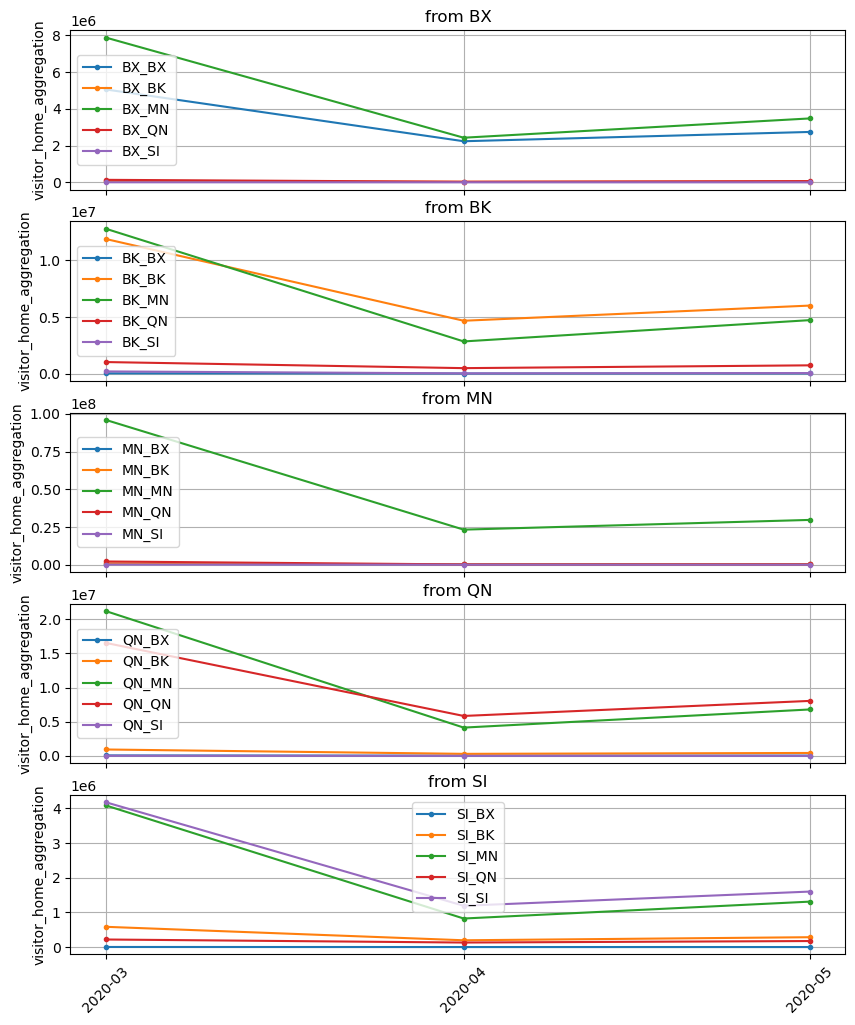

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


fig, ax = plt.subplots(5, figsize=(10,12), sharex=True)

for i, o in enumerate(nyc_df["orig"].unique()):
    paths = nyc_df.loc[nyc_df.orig == o, "path"].unique()
    for path in paths:
        ax[i].plot(
            nyc_df.loc[nyc_df['path'] == path, 'DATE_RANGE_START'],
            nyc_df.loc[nyc_df['path'] == path, 'visitor_home_aggregation'].values, '.-', label=path)
    ax[i].set_title(f"from {o}")
    ax[i].set_ylabel(r'visitor_home_aggregation')
    ax[i].grid()
    ax[i].legend()
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.xticks(rotation=45)

From the old weekly Safegraph version

![alt text](../assets/safegraph.png)

## Try to derive daily data from `visitor_home_aggregation` and `visits_by_day`

In [69]:
from tqdm.auto import tqdm

# ratio between vistor and visits
files = glob.glob("/burg/apam/users/nhw2114/safegraph/raw/*.gz")    
visit_counts = {}
visitor_counts = {}

fields = ['DATE_RANGE_START', 'RAW_VISIT_COUNTS', 'RAW_VISITOR_COUNTS']

for file in tqdm(files):
    df = pd.read_csv(file, usecols=fields)
    df['DATE_RANGE_START'] = pd.to_datetime(df['DATE_RANGE_START'])
    date_key = df.loc[0,'DATE_RANGE_START'].strftime('%Y_%m_%d')
    visit_counts[date_key] = visit_counts.get(date_key, 0) + df['RAW_VISIT_COUNTS'].sum()
    visitor_counts[date_key] = visitor_counts.get(date_key,0) + df['RAW_VISITOR_COUNTS'].sum()

print('visit_counts', visit_counts)
print('visitor counts', visitor_counts)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [18:20<00:00,  8.46s/it]

visit_counts {'2020_03_01': 5340263611.0, '2020_04_01': 2664949925.0, '2020_05_01': 3600284217.0}
visitor counts {'2020_03_01': 2935380809.0, '2020_04_01': 1322090599.0, '2020_05_01': 1922153084.0}


In [75]:
for k, v in visitor_counts.items():
    print(k, ' ratio: ', visit_counts[k] / v)

2020_03_01  ratio:  1.8192745536206167
2020_04_01  ratio:  2.0157090043720975
2020_05_01  ratio:  1.8730475980132704


In [74]:
1 / (sum(visitor_counts.values()) / sum(visit_counts.values()))

1.8780263700527777

On average, the visit to visitor ratio is 1.88.

In [130]:
nyc_daily_df = nyc_df.copy()

In [131]:
visit_day_cols = [col for col in nyc_df.columns if 'DAY' in col]

def normalize_days(x):
    x[visit_day_cols] = x['visitor_home_aggregation'] * x[visit_day_cols] / x[visit_day_cols].sum()
    return x

nyc_daily_df = nyc_daily_df.apply(normalize_days, axis=1)

In [129]:
nyc_df.loc[nyc_df.DATE_RANGE_START == '2020-04-01']

,DATE_RANGE_START,DATE_RANGE_END,COUNTY_ORIG,COUNTY_DEST,visitor_home_aggregation,VISITS_DAY_0,VISITS_DAY_1,VISITS_DAY_2,VISITS_DAY_3,VISITS_DAY_4,...,VISITS_DAY_24,VISITS_DAY_25,VISITS_DAY_26,VISITS_DAY_27,VISITS_DAY_28,VISITS_DAY_29,VISITS_DAY_30,orig,dest,path
928067,2020-04-01,2020-05-01,36005,36005,2235437,15199286,14794839,15105003,13269894,10525216,...,14323446,9875464,14590050,16116810,14961819,14620666,0.0,BX,BX,BX_BX
928076,2020-04-01,2020-05-01,36005,36047,30760,636739,640456,620813,457062,365371,...,573493,366850,635983,722889,670053,630735,0.0,BX,BK,BX_BK
928080,2020-04-01,2020-05-01,36005,36061,2427205,77718624,71725793,71595108,51457267,44717415,...,65689599,43224366,76953544,87444576,80265881,75285884,0.0,BX,MN,BX_MN
928085,2020-04-01,2020-05-01,36005,36081,33253,1542378,1428810,1517238,1140162,985804,...,1279490,989090,1465200,1719172,1545492,1585835,0.0,BX,QN,BX_QN
928087,2020-04-01,2020-05-01,36005,36085,400,9402,9085,9130,7680,6584,...,8431,6210,8315,9188,8106,8798,0.0,BX,SI,BX_SI
930416,2020-04-01,2020-05-01,36047,36005,12113,365697,360359,353607,279726,226648,...,322044,218249,347220,397668,365509,357239,0.0,BK,BX,BK_BX
930428,2020-04-01,2020-05-01,36047,36047,4669640,54032935,54161130,52241364,43879989,34014599,...,55022766,34958289,54507004,60944682,54672494,54276393,0.0,BK,BK,BK_BK
930433,2020-04-01,2020-05-01,36047,36061,2843404,66114054,61950138,61823476,41863718,36572155,...,55522829,36998690,66843366,74225486,68879881,66006601,0.0,BK,MN,BK_MN
930439,2020-04-01,2020-05-01,36047,36081,486943,49434830,47160381,47124303,40247850,35169528,...,51434652,34912088,48276216,58307626,51375872,51397301,0.0,BK,QN,BK_QN
930440,2020-04-01,2020-05-01,36047,36085,25281,2112737,2037125,1922240,2003735,1719410,...,2726422,1469830,2043883,2812431,2130491,2098065,0.0,BK,SI,BK_SI


In [137]:
nyc_daily_df.DATE_RANGE_START.unique()

<DatetimeArray>
['2020-03-01 00:00:00', '2020-04-01 00:00:00', '2020-05-01 00:00:00']
Length: 3, dtype: datetime64[ns]

In [138]:
nyc_daily_df.loc[nyc_daily_df.DATE_RANGE_START == '2020-03-01', 'VISITS_DAY_30']

379019     84036.957326
379035       826.820763
379040     81667.489982
379048      1433.679264
379050        28.860836
382738       482.011650
382757    166261.484034
382762    110413.630015
382771     13240.221149
382773      1127.223091
384670      9624.817939
384683     10128.278356
384689    820851.520718
384696     23363.011300
384698      1032.144351
387173      1168.853146
387188     13122.746397
387194    179558.009147
387203    193179.301290
387205       227.166480
387623        57.925775
387635      8744.662035
387638     32405.464400
387646      3656.887965
387648     45783.723890
Name: VISITS_DAY_30, dtype: float64

In [139]:
nyc_daily_df = pd.wide_to_long(nyc_daily_df, 'VISITS_DAY_', i=['DATE_RANGE_START', 'DATE_RANGE_END', 'COUNTY_ORIG', 'COUNTY_DEST'], j='day').reset_index()

In [144]:
nyc_daily_df.drop(nyc_daily_df.loc[(nyc_daily_df.DATE_RANGE_START == '2020-04-01') & (nyc_daily_df.day == 30)].index, inplace=True)

In [145]:
import datetime

def create_day(x):
    x['day'] = datetime.timedelta(x['day']) + x['DATE_RANGE_START']
    return x

nyc_daily_df = nyc_daily_df.apply(create_day, axis=1)

In [146]:
nyc_daily_df.head()

,DATE_RANGE_START,DATE_RANGE_END,COUNTY_ORIG,COUNTY_DEST,day,dest,orig,path,visitor_home_aggregation,VISITS_DAY_
0,2020-03-01,2020-04-01,36005,36005,2020-03-01,BX,BX,BX_BX,5052262,174926.129784
1,2020-03-01,2020-04-01,36005,36005,2020-03-02,BX,BX,BX_BX,5052262,257740.702670
2,2020-03-01,2020-04-01,36005,36005,2020-03-03,BX,BX,BX_BX,5052262,253584.989646
3,2020-03-01,2020-04-01,36005,36005,2020-03-04,BX,BX,BX_BX,5052262,262451.617560
4,2020-03-01,2020-04-01,36005,36005,2020-03-05,BX,BX,BX_BX,5052262,257552.754587


(array([18321., 18322., 18328., 18329., 18335., 18336., 18342., 18343.,
        18349., 18350., 18356., 18357., 18363., 18364., 18370., 18371.,
        18377., 18378., 18384., 18385., 18391., 18392., 18398., 18399.,
        18405., 18406., 18412., 18413.]),
 [Text(18321.0, 0, '2020-02-29'),
  Text(18322.0, 0, '2020-03-01'),
  Text(18328.0, 0, '2020-03-07'),
  Text(18329.0, 0, '2020-03-08'),
  Text(18335.0, 0, '2020-03-14'),
  Text(18336.0, 0, '2020-03-15'),
  Text(18342.0, 0, '2020-03-21'),
  Text(18343.0, 0, '2020-03-22'),
  Text(18349.0, 0, '2020-03-28'),
  Text(18350.0, 0, '2020-03-29'),
  Text(18356.0, 0, '2020-04-04'),
  Text(18357.0, 0, '2020-04-05'),
  Text(18363.0, 0, '2020-04-11'),
  Text(18364.0, 0, '2020-04-12'),
  Text(18370.0, 0, '2020-04-18'),
  Text(18371.0, 0, '2020-04-19'),
  Text(18377.0, 0, '2020-04-25'),
  Text(18378.0, 0, '2020-04-26'),
  Text(18384.0, 0, '2020-05-02'),
  Text(18385.0, 0, '2020-05-03'),
  Text(18391.0, 0, '2020-05-09'),
  Text(18392.0, 0, '2020-05-

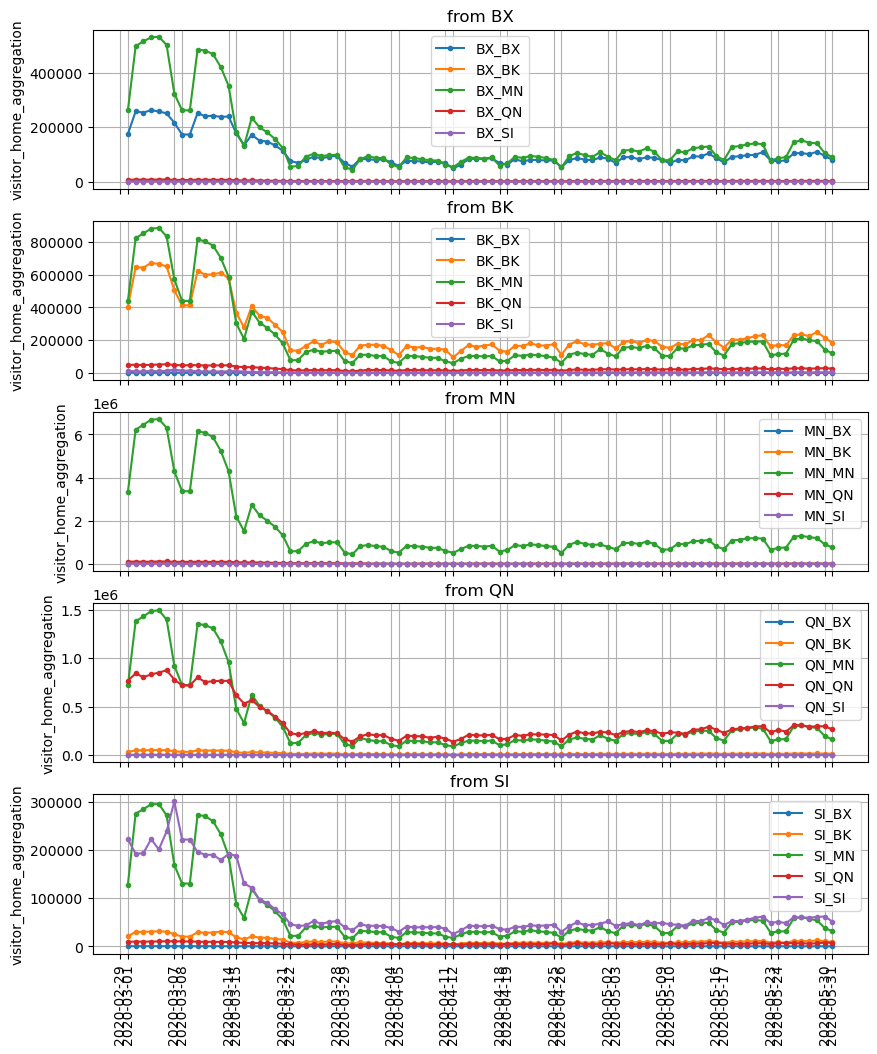

In [147]:
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

fig, ax = plt.subplots(5, figsize=(10,12), sharex=True)

for i, o in enumerate(nyc_daily_df["orig"].unique()):
    paths = nyc_daily_df.loc[nyc_daily_df.orig == o, "path"].unique()
    for path in paths:
        ax[i].plot(
            nyc_daily_df.loc[nyc_daily_df['path'] == path, 'day'],
            nyc_daily_df.loc[nyc_daily_df['path'] == path, 'VISITS_DAY_'].values, '.-', label=path)
    ax[i].set_title(f"from {o}")
    ax[i].set_ylabel(r'visitor_home_aggregation')
    ax[i].grid()
    ax[i].legend()
    ax[i].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=[SA, SU]))

plt.xticks(rotation=90)

# Polars code (currently unstable)

In [1]:
import pandas as pd
import numpy as np
import glob

import os, gzip, shutil

from tqdm import tqdm

import polars as pl

import matplotlib.pyplot as plt
import itertools

## Unzip files

In [2]:
# dir_name = "/Users/hwunrow/Documents/GitHub/e6691-2024spring-project-cgnn-nhw2114/data/raw/safegraph/"

# def gz_extract(directory):
#     extension = ".gz"
#     for item in tqdm(os.listdir(directory)): # loop through items in dir
#       if item.endswith(extension): # check for ".gz" extension
#           gz_name = os.path.abspath(item) # get full path of files
#           file_name = (os.path.basename(gz_name)).rsplit('.',1)[0] #get file name for file within
#           with gzip.open(gz_name,"rb") as f_in, open(file_name,"wb") as f_out:
#               shutil.copyfileobj(f_in, f_out)
#           os.remove(gz_name) # delete zipped file
        
# gz_extract(dir_name)

## Open first file and investigate columns

In [3]:
# def combine_batch_csv(dir):
#     """Combines Safegraph dataframes into one
#     """
#     csv_files = glob.glob(f'{dir}/*.csv.gz')

#     df_list = []

#     for filename in tqdm(csv_files):
#         df = pd.read_csv(example_file, compression='gzip')
#         df_list.append(df)

#     df = pd.concat(df_list, axis=0)

#     return df

In [4]:
dir = "../data/raw/safegraph/*.csv"
file_paths = glob.glob(dir)

df = pl.read_csv(file_paths[0])

In [5]:
def polars_sum_values_or_zero(x):
    if x == '':
        return 0
    else:
        return sum(json.loads(x).values())

# def pandas_sum_values_or_zero(x):
#     if pd.isna(x):
#         return 0
#     else:
#         return sum(json.loads(x).values())

df = df.with_columns(
    pl.col("VISITOR_HOME_AGGREGATION").apply(polars_sum_values_or_zero).alias('VISITOR_HOME_AGGREGATION_TOTAL'),
    pl.col("VISITOR_HOME_CBGS").apply(polars_sum_values_or_zero).alias('VISITOR_HOME_CBGS_TOTAL'),
    pl.col("VISITOR_DAYTIME_CBGS").apply(polars_sum_values_or_zero).alias('VISITOR_DAYTIME_CBGS_TOTAL'),
)


/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_91028/3749972135.py:14: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("VISITOR_HOME_AGGREGATION").apply(polars_sum_values_or_zero).alias('VISITOR_HOME_AGGREGATION_TOTAL'),
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_91028/3749972135.py:15: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("VISITOR_HOME_CBGS").apply(polars_sum_values_or_zero).alias('VISITOR_HOME_CBGS_TOTAL'),
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_91028/3749972135.py:16: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("VISITOR_DAYTIME_CBGS").apply(polars_sum_values_or_zero).alias('VISITOR_DAYTIME_CBGS_TOTAL'),
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithout

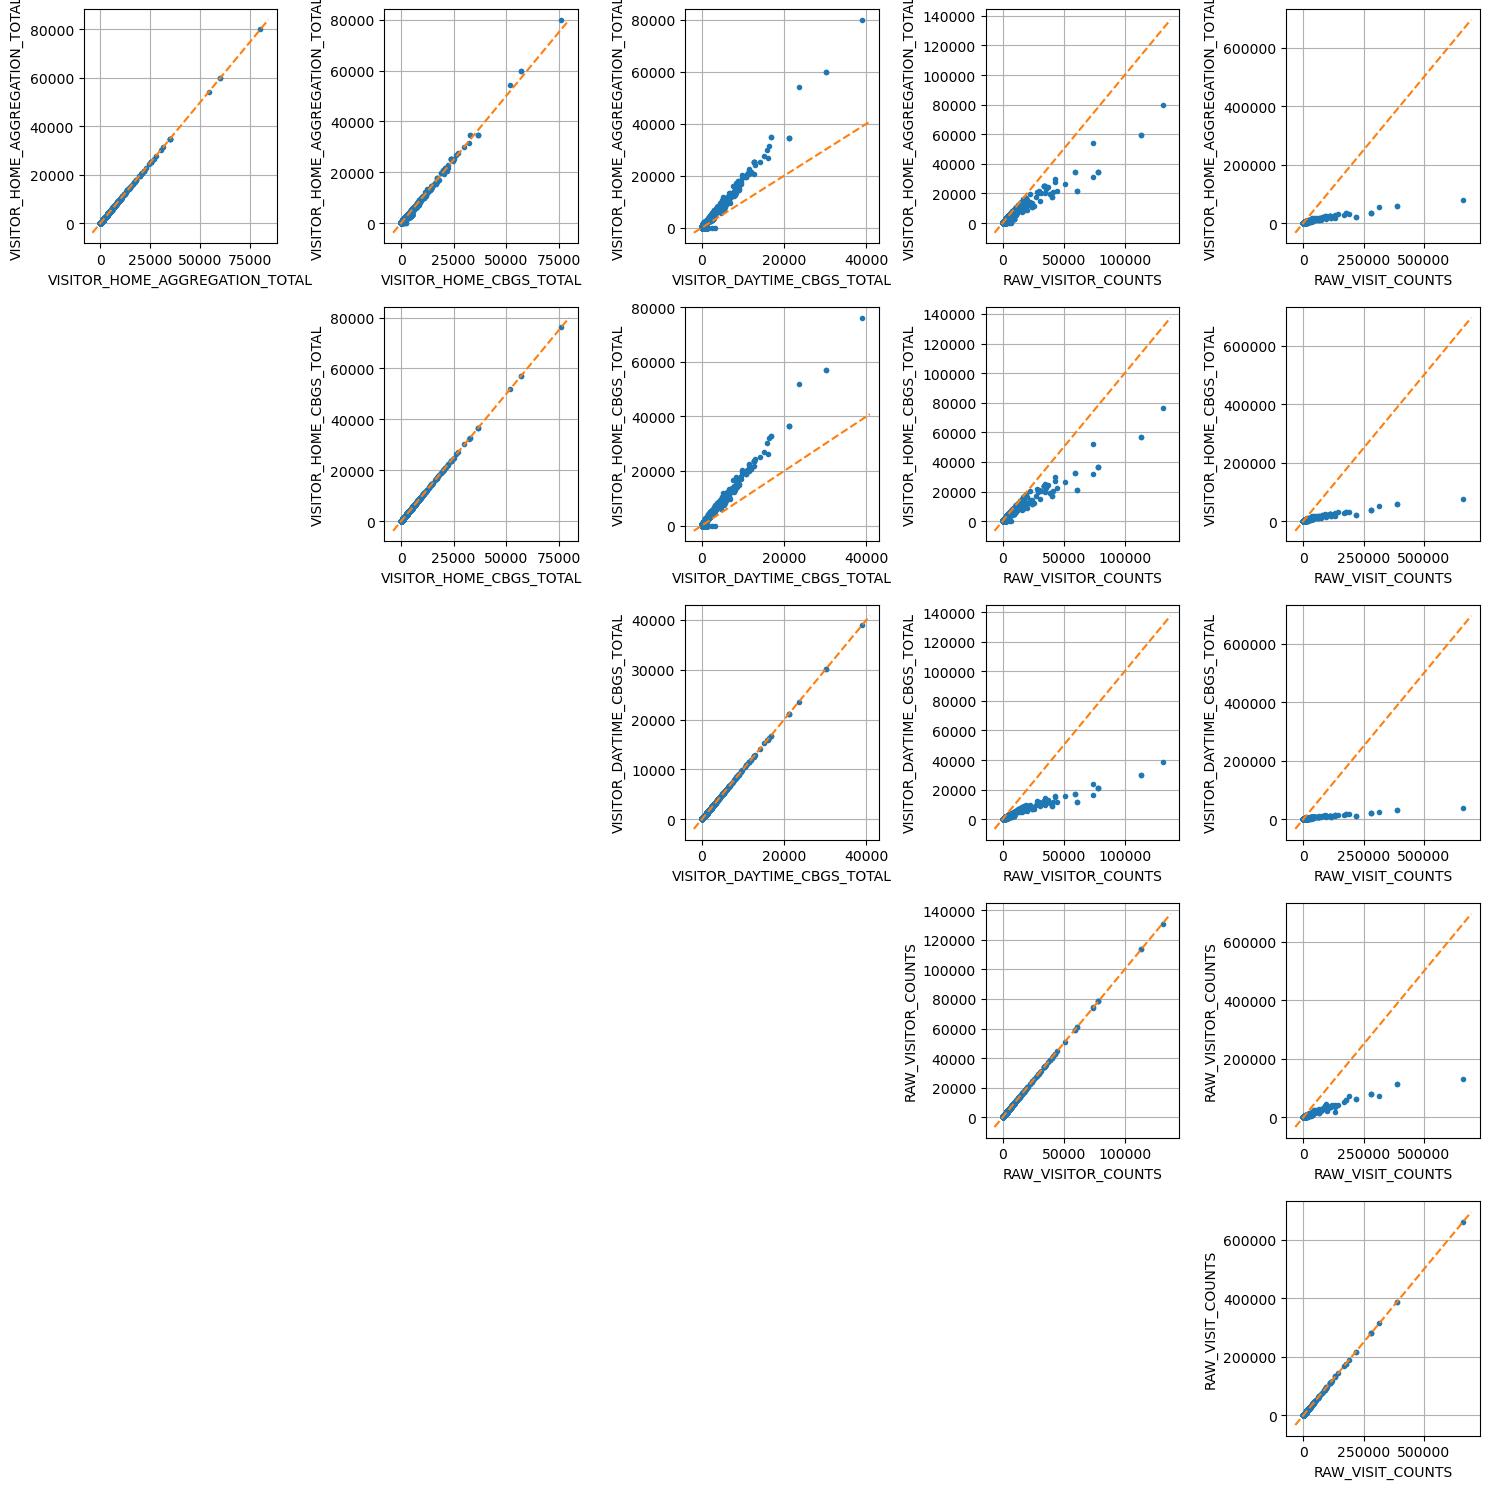

In [6]:
fig, axs = plt.subplots(figsize=(15,15), ncols= 5, nrows=5)

cols = ['VISITOR_HOME_AGGREGATION_TOTAL', 'VISITOR_HOME_CBGS_TOTAL', 'VISITOR_DAYTIME_CBGS_TOTAL', 'RAW_VISITOR_COUNTS', 'RAW_VISIT_COUNTS']
plot_col_pairs = list(itertools.product(cols, cols))

for i, ax in enumerate(axs.flatten()):
    col_a, col_b = plot_col_pairs[i]
    col = i % 5
    row = i // 5
    if col >= row:
        ax.plot(df[col_b], df[col_a], '.')
        x_vals = np.array(ax.get_xlim())
        ax.plot(x_vals, x_vals, '--')
    
        ax.set_xlabel(col_b)
        ax.set_ylabel(col_a)
        ax.grid()
    else:
        ax.set_axis_off()

plt.tight_layout()

In [7]:
# df.loc[:,['VISITOR_HOME_AGGREGATION_TOTAL', 'VISITOR_HOME_CBGS_TOTAL', 'VISITOR_DAYTIME_CBGS_TOTAL', 'RAW_VISITOR_COUNTS', 'RAW_VISIT_COUNTS']].sum(axis=0)
df.select(
    pl.col("VISITOR_HOME_AGGREGATION_TOTAL").sum(),
    pl.col("VISITOR_HOME_CBGS_TOTAL").sum(),
    pl.col("VISITOR_DAYTIME_CBGS_TOTAL").sum(),
    pl.col("RAW_VISITOR_COUNTS").sum(),
    pl.col("RAW_VISIT_COUNTS").sum(),
)

VISITOR_HOME_AGGREGATION_TOTAL,VISITOR_HOME_CBGS_TOTAL,VISITOR_DAYTIME_CBGS_TOTAL,RAW_VISITOR_COUNTS,RAW_VISIT_COUNTS
i64,i64,i64,i64,i64
28435742,26629594,13353389,34765969,71299124


```
VISITOR_DAYTIME_CBGS_TOTAL <<  VISITOR_HOME_CBGS_TOTAL \approx VISITOR_HOME_AGGREGATION_TOTAL < RAW_VISITOR_COUNTS << RAW_VISIT_COUNTS
```

## Open all files

In [33]:
path = "../data/raw/safegraph/*.csv"
df = pl.scan_csv(path, dtypes = {"POSTAL_CODE": pl.String}).filter(
    pl.col("VISITS_BY_DAY") != "",
    pl.col("VISITOR_HOME_AGGREGATION") != "",
)

df = df.with_columns(
    pl.col("DATE_RANGE_START").str.to_datetime(),
    pl.col("DATE_RANGE_END").str.to_datetime()
)



In [34]:
zip_county_map = pd.read_csv('../data/raw/ZIP_COUNTY_CROSSWALK.csv')
tract_zip_map = pd.read_csv('../data/raw/ZIP_TRACT_032020.csv')

# keep the zip-county pair that has the highest TOT_RATIO
zip_county_map = zip_county_map.sort_values(by=['ZIP', 'TOT_RATIO'], ascending=False)
zip_county_map = zip_county_map.drop_duplicates(subset='ZIP', keep='first')

# map codes to strings (probably should make everything ints, but it's just annoying since there are some alphnumeric postal codes in safegraph
zip_county_map['ZIP'] = zip_county_map['ZIP'].astype(str)
zip_county_map['COUNTY'] = zip_county_map['COUNTY'].astype(str)

tract_zip_map['ZIP'] = tract_zip_map['ZIP'].astype(str)
tract_zip_map['TRACT'] = tract_zip_map['TRACT'].astype(str)

# merge county to postal code of POI
df = df.join(pl.from_pandas(zip_county_map[['ZIP','COUNTY']]).lazy(), left_on='POSTAL_CODE', right_on='ZIP', how='left')

df = df.filter(
    pl.col('COUNTY').is_in(['36005', '36047', '36061', '36081', '36085'])
)


In [35]:
# count number of POIs with no county
# crap_df = df.select(
#     pl.col("COUNTY").is_null(),
#     pl.len()
# ).collect()

# crap_df['COUNTY'].sum() / crap_df['len'][0]

0.0

Around 7% of rows of Safegraph data does not have a postal code/ zip code that maps to a US county. Many of them are Canadian zip codes. Just drop them for now.

In [36]:
import polars.selectors as cs

decoded_df = df.select(
    pl.col('DATE_RANGE_START'),
    pl.col('DATE_RANGE_END'),
    pl.col('COUNTY'),
    pl.col("VISITOR_HOME_AGGREGATION").str.json_decode()
).unnest('VISITOR_HOME_AGGREGATION')

decoded_df = decoded_df.melt(id_vars=['DATE_RANGE_START','DATE_RANGE_END','COUNTY'], value_vars=cs.numeric(), variable_name='TRACT', value_name='VISITOR_HOME_AGGREGATION')
decoded_df = decoded_df.join(pl.from_pandas(tract_zip_map[['ZIP','TRACT']]).lazy(), left_on='TRACT', right_on='TRACT', how='left')
decoded_df = decoded_df.join(pl.from_pandas(zip_county_map[['ZIP','COUNTY']]).lazy(), left_on='ZIP', right_on='ZIP', how='left', suffix='_dest')
decoded_df = decoded_df.drop("TRACT", "ZIP")

In [ ]:
decoded_df = decoded_df.filter(
    ~pl.col('COUNTY').is_null(),
    ~pl.col('COUNTY_dest').is_null(),
    ~pl.col('VISITOR_HOME_AGGREGATION').is_null(),
)

nyc_df = decoded_df.group_by(by=["DATE_RANGE_START", "DATE_RANGE_END", "COUNTY", "COUNTY_dest"]).sum().collect()

/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_93326/3864176317.py:7: DeprecationWarning: named `by` param is deprecated; use positional `*args` instead.
  nyc_df = decoded_df.group_by(by=["DATE_RANGE_START", "DATE_RANGE_END", "COUNTY", "COUNTY_dest"]).sum().collect()


In [ ]:
nyc_df = nyc_df.select(
    pl.col("COUNTY").cast(pl.Int16),
    pl.col("COUNTY_dest").cast(pl.Int16),
)

In [ ]:
from utils.codebook import FIPS_BOROUGH_MAP

In [ ]:
mobility_df = pd.concat(df_list)
mobility_df["path"] = mobility_df["origin"] + "_" + mobility_df["destination"]
mobility_df["date"] = pd.to_datetime(mobility_df["end"])

fig, ax = plt.subplots(5, figsize=(10,12), sharex=True)


for i, o in enumerate(mobility_df["origin"].unique()):
    paths = mobility_df.loc[mobility_df.origin == o, "path"].unique()
    for path in paths:
        ax[i].plot(
            mobility_df.loc[mobility_df['path'] == path, 'date'],
            mobility_df.loc[mobility_df['path'] == path, 'visitor_home_aggregation'].values, '-', label=path)
    ax[i].set_title(f"from {o}")
    ax[i].set_ylabel(r'visitor_home_aggregation')
    ax[i].grid()
    ax[i].legend()

fig.suptitle("Safegraph Mobility Data")
fig.savefig("../assets/safegraph.png")
